In [1]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, PrecisionRecallDisplay

# --- 1. Chargement des données propres ---
print("Chargement des données...")
train_df = pl.read_parquet("../data/processed/train.parquet")
test_df = pl.read_parquet("../data/processed/test.parquet")

# --- 2. Conversion X/y pour Scikit-Learn ---
# On retire la cible et la date (devenue inutile après le feature engineering)
features_to_drop = ["FlagImpaye", "DateTransaction"]

X_train = train_df.drop(features_to_drop).to_pandas()
y_train = train_df["FlagImpaye"].to_numpy()

X_test = test_df.drop(features_to_drop).to_pandas()
y_test = test_df["FlagImpaye"].to_numpy()

print(f"Train : {X_train.shape}")
print(f"Test  : {X_test.shape}")

Chargement des données...
Train : (3899362, 18)
Test  : (747411, 18)


In [2]:
from imblearn.under_sampling import RandomUnderSampler

# --- 3. Baseline : Random Forest avec Undersampling ---
print("\n--- Préparation Baseline (Undersampling) ---")

# On définit une stratégie : 'auto' veut dire "autant de 0 que de 1" (ratio 1:1)
# C'est radical mais ultra-rapide pour tester.
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# IMPORTANT : On ne resample QUE le train set !
print(f"Avant resample : {X_train.shape}")
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
print(f"Après resample : {X_train_res.shape}") 
# Tu devrais tomber à environ 40k ou 50k lignes (beaucoup plus rapide !)

print("\n--- Entraînement Random Forest (Sur données réduites) ---")
# Plus besoin de class_weight='balanced' car on a forcé l'équilibre 50/50
rf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1
)

rf_model.fit(X_train_res, y_train_res)

# Évaluation sur le VRAI test set (qui lui est toujours déséquilibré)
print("Évaluation sur le Test Set...")
y_pred_rf = rf_model.predict(X_test)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"Baseline F-Mesure (Undersampling 1:1) : {f1_rf:.4f}")
print("\nMatrice de Confusion :")
print(confusion_matrix(y_test, y_pred_rf))


--- Préparation Baseline (Undersampling) ---
Avant resample : (3899362, 18)
Après resample : (46844, 18)

--- Entraînement Random Forest (Sur données réduites) ---
Évaluation sur le Test Set...
Baseline F-Mesure (Undersampling 1:1) : 0.0363

Matrice de Confusion :
[[510440 230398]
 [  2188   4385]]



--- Optimisation du Seuil de Décision (Threshold Tuning) ---
Meilleur Seuil trouvé : 0.9500
Meilleure F-Mesure théorique : 0.0835

--- Performance avec Seuil Ajusté ---
[[733273   7565]
 [  5957    616]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    740838
           1       0.08      0.09      0.08      6573

    accuracy                           0.98    747411
   macro avg       0.53      0.54      0.54    747411
weighted avg       0.98      0.98      0.98    747411



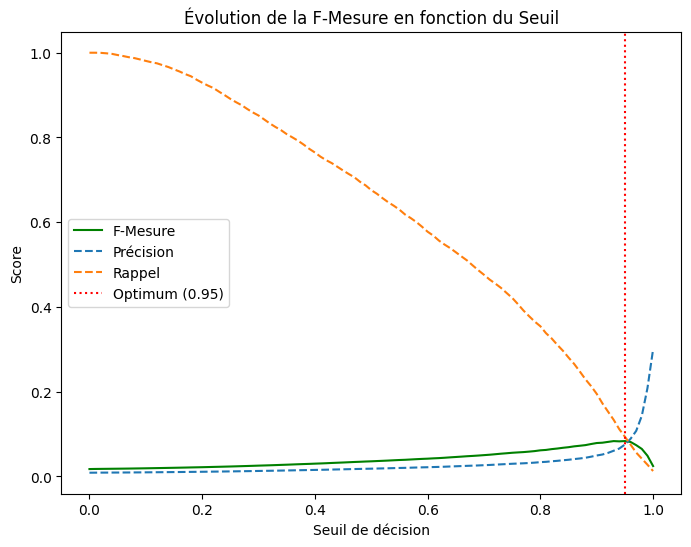

In [3]:
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

print("\n--- Optimisation du Seuil de Décision (Threshold Tuning) ---")

# 1. Obtenir les PROBABILITÉS au lieu des classes brutes (0 ou 1)
# On s'intéresse à la probabilité d'être classe 1 (Fraude)
y_scores = rf_model.predict_proba(X_test)[:, 1]

# 2. Calculer Précision, Rappel et Seuils pour toutes les valeurs possibles
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# 3. Calculer la F-Mesure pour chaque seuil
# F1 = 2 * (P * R) / (P + R)
# On ajoute une petite valeur (epsilon) pour éviter la division par zéro
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# 4. Trouver le meilleur seuil (argmax)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Meilleur Seuil trouvé : {best_threshold:.4f}")
print(f"Meilleure F-Mesure théorique : {best_f1:.4f}")

# 5. Appliquer ce seuil pour voir la Matrice de Confusion finale
y_pred_tuned = (y_scores >= best_threshold).astype(int)

print("\n--- Performance avec Seuil Ajusté ---")
print(confusion_matrix(y_test, y_pred_tuned))
print(classification_report(y_test, y_pred_tuned))

# (Optionnel) Visualisation de la courbe Précision-Rappel et du pic F1
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], label="F-Mesure", color="green")
plt.plot(thresholds, precisions[:-1], label="Précision", linestyle="--")
plt.plot(thresholds, recalls[:-1], label="Rappel", linestyle="--")
plt.axvline(best_threshold, color='red', linestyle=':', label=f'Optimum ({best_threshold:.2f})')
plt.xlabel("Seuil de décision")
plt.ylabel("Score")
plt.title("Évolution de la F-Mesure en fonction du Seuil")
plt.legend()
plt.show()

In [4]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np

print("\n--- Entraînement CHALLENGER : XGBoost ---")

# 1. Calcul du ratio pour l'équilibrage (scale_pos_weight)
# C'est la recommandation de la doc XGBoost pour les données déséquilibrées
# Ratio = (Nombre de Négatifs) / (Nombre de Positifs)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
print(f"Ratio de déséquilibre calculé : {ratio:.2f}")

# 2. Modèle XGBoost
# On utilise tree_method='hist' pour aller BEAUCOUP plus vite sur les gros datasets
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,             # Profondeur modérée pour éviter l'overfitting
    scale_pos_weight=ratio,  # La clé pour gérer le déséquilibre sans undersampling
    tree_method='hist',      # Optimisation vitesse (histogram-based)
    device="cpu",            # Mets "cuda" si tu as un GPU Nvidia configuré
    random_state=42,
    n_jobs=-1
)

# On entraîne sur le dataset complet (X_train) car 'hist' est très rapide
# Plus besoin de l'undersampling ici !
xgb_model.fit(X_train, y_train)

# 3. Prédiction (Probabilités)
print("Prédiction en cours...")
y_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]

# 4. Optimisation du Seuil (La même technique que tout à l'heure)
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs_xgb)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold_xgb = thresholds[best_idx]
best_f1_xgb = f1_scores[best_idx]

print(f"\n--- Résultats XGBoost Optimisé ---")
print(f"Meilleur Seuil : {best_threshold_xgb:.4f}")
print(f"Meilleure F-Mesure : {best_f1_xgb:.4f}")

# 5. Matrice finale
y_pred_xgb_tuned = (y_probs_xgb >= best_threshold_xgb).astype(int)
print(confusion_matrix(y_test, y_pred_xgb_tuned))
print(classification_report(y_test, y_pred_xgb_tuned))


--- Entraînement CHALLENGER : XGBoost ---
Ratio de déséquilibre calculé : 165.48
Prédiction en cours...

--- Résultats XGBoost Optimisé ---
Meilleur Seuil : 0.9249
Meilleure F-Mesure : 0.1496
[[736402   4436]
 [  5683    890]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    740838
           1       0.17      0.14      0.15      6573

    accuracy                           0.99    747411
   macro avg       0.58      0.56      0.57    747411
weighted avg       0.99      0.99      0.99    747411



## fine tuning xgboost RrandomizedSearch

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

print("--- Démarrage du Tuning XGBoost (Approche 'GBtune') ---")

# 1. Définition de l'espace de recherche (Hyperparameter Space)
param_dist = {
    'max_depth': randint(3, 10),           # Tester des arbres simples et complexes
    'learning_rate': uniform(0.01, 0.2),   # Vitesse d'apprentissage
    'n_estimators': randint(100, 300),     # Nombre d'arbres
    'min_child_weight': randint(1, 10),    # Crucial pour l'imbalanced
    'gamma': uniform(0, 0.5),              # Régularisation (Précision)
    'subsample': uniform(0.6, 0.4),        # 0.6 à 1.0
    'colsample_bytree': uniform(0.6, 0.4)  # 0.6 à 1.0
}

# 2. Modèle de base
xgb_base = XGBClassifier(
    scale_pos_weight=ratio, # On garde notre atout majeur
    tree_method='hist',     # Toujours pour la vitesse
    random_state=42,
    n_jobs=-1
)

# 3. Randomized Search
# On va tester 20 combinaisons au hasard (n_iter=20)
random_search = RandomizedSearchCV(
    xgb_base, 
    param_distributions=param_dist, 
    n_iter=20,             # Tester 20 configurations
    scoring='f1',          # Objectif : F-Mesure (comme la thèse Partie 1)
    cv=3, 
    verbose=1, 
    random_state=42,
    n_jobs=-1
)

# Astuce : Pour aller vite, on peut tuner sur un sous-échantillon (ex: 20% du train)
# Mais pour être précis, on lance sur tout X_train (ça peut prendre 10-20 min)
random_search.fit(X_train, y_train)

print(f"Meilleurs paramètres : {random_search.best_params_}")
print(f"Meilleur score CV (F1) : {random_search.best_score_:.4f}")

# 4. Évaluation du modèle Tuné
best_xgb = random_search.best_estimator_
y_probs_tuned = best_xgb.predict_proba(X_test)[:, 1]


--- Démarrage du Tuning XGBoost (Approche 'GBtune') ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

In [8]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint, uniform

# 1. Sous-échantillonnage Stratifié (20% des données pour le tuning)
print("Création du sous-échantillon de tuning...")
X_tune, _, y_tune, _ = train_test_split(
    X_train, y_train, 
    test_size=0.8,      # On garde 20% pour le tuning
    stratify=y_train,   # On garde le ratio de fraude
    random_state=42
)
print(f"Tuning sur {X_tune.shape[0]} lignes (au lieu de {X_train.shape[0]})")

# 2. Config sans conflit
# On laisse XGBoost utiliser tous les cœurs (n_jobs=-1)
# Mais on force le Search à être séquentiel (n_jobs=1) pour éviter la surcharge
xgb_base = XGBClassifier(
    scale_pos_weight=ratio,
    tree_method='hist',
    n_jobs=-1,          # XGBoost = Parallèle
    random_state=42
)

param_dist = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.05, 0.2), # Un peu plus haut pour converger vite
    'n_estimators': randint(100, 300),
    'min_child_weight': randint(1, 8),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=15,          # 15 itérations suffisent souvent
    scoring='f1',
    cv=3,
    n_jobs=1,           # Search = Séquentiel (CRUCIAL)
    verbose=1,
    random_state=42
)

print("Lancement du Tuning Rapide...")
search.fit(X_tune, y_tune)

print(f"Meilleurs paramètres : {search.best_params_}")

# 3. Ré-entraînement du "Champion" sur TOUT le dataset
print("\nEntraînement final du meilleur modèle sur tout le Train Set...")
best_xgb = XGBClassifier(**search.best_params_, scale_pos_weight=ratio, tree_method='hist', n_jobs=-1, random_state=42)
best_xgb.fit(X_train, y_train)

# Evaluation
y_probs_final = best_xgb.predict_proba(X_test)[:, 1]
# ... (Calcul du seuil optimal et score F1 ici)

Création du sous-échantillon de tuning...
Tuning sur 779872 lignes (au lieu de 3899362)
Lancement du Tuning Rapide...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Meilleurs paramètres : {'colsample_bytree': np.float64(0.8349262400109296), 'gamma': np.float64(0.1975751180009072), 'learning_rate': np.float64(0.23533177315875886), 'max_depth': 9, 'min_child_weight': 7, 'n_estimators': 299, 'subsample': np.float64(0.8711331923216198)}

Entraînement final du meilleur modèle sur tout le Train Set...


In [10]:
# Optimisation du seuil sur ce nouveau modèle
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs_final)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_idx = np.argmax(f1_scores)
print(f"F-Mesure après Tuning : {f1_scores[best_idx]:.4f}")

F-Mesure après Tuning : 0.0921


## partie 2



--- PARTIE 2 : MAXIMISATION DU PROFIT (RÈGLES MÉTIER) ---
Recherche du seuil qui maximise le Profit...
--- RÉSULTATS FINANCIERS ---
Meilleur Seuil de décision : 0.88
Profit Maximum estimé      : 2,137,738.63 €
Profit avec seuil 0.5      : 1,933,809.98 €
-> Gain grâce à l'optimisation : +203,928.65 €


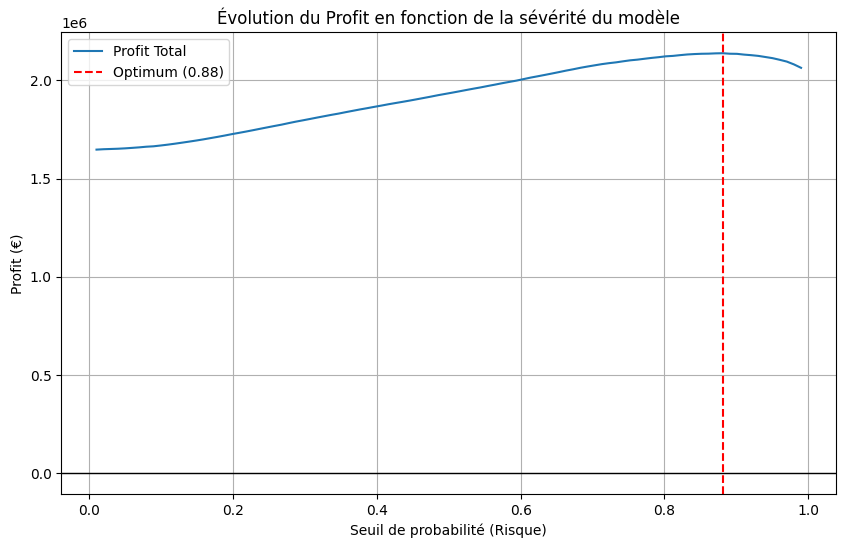

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("\n--- PARTIE 2 : MAXIMISATION DU PROFIT (RÈGLES MÉTIER) ---")

# 1. La Formule Exacte du Profit (Selon ta consigne)
def calculate_exact_profit(y_true, y_probs, threshold, amounts):
    y_true = np.array(y_true)
    amounts = np.array(amounts)
    
    # Décision basée sur le seuil
    y_pred = (y_probs >= threshold).astype(int)
    
    # --- Cas 1 : Vrais Négatifs (Acceptation Légitime) ---
    # [cite_start]Gain = 5% du montant [cite: 85]
    mask_tn = (y_true == 0) & (y_pred == 0)
    gain_tn = np.sum(amounts[mask_tn] * 0.05)
    
    # --- Cas 2 : Faux Positifs (Refus Légitime) ---
    # [cite_start]Gain = 70% de la marge habituelle [cite: 90]
    # Donc 0.7 * 0.05 * m = 0.035 * m
    mask_fp = (y_true == 0) & (y_pred == 1)
    gain_fp = np.sum(amounts[mask_fp] * 0.035)
    
    # --- Cas 3 : Vrais Positifs (Refus Fraude) ---
    # [cite_start]"Ni perte ni gain" [cite: 91] -> 0
    
    # --- Cas 4 : Faux Négatifs (Acceptation Fraude) ---
    # [cite_start]Perte selon les paliers [cite: 89] (Corrigé avec tes valeurs)
    mask_fn = (y_true == 1) & (y_pred == 0)
    fn_amounts = amounts[mask_fn]
    fn_losses = np.zeros_like(fn_amounts)
    
    # m <= 20 : 0
    # 20 < m <= 50 : 0.2 * m
    mask_20_50 = (fn_amounts > 20) & (fn_amounts <= 50)
    fn_losses[mask_20_50] = 0.2 * fn_amounts[mask_20_50]
    
    # 50 < m <= 200 : 0.3 * m (Supposition logique, le sujet dit 50 < m < 200)
    mask_50_200 = (fn_amounts > 50) & (fn_amounts <= 200)
    fn_losses[mask_50_200] = 0.3 * fn_amounts[mask_50_200]
    
    # m > 200 : 0.5 * m
    mask_200 = (fn_amounts > 200)
    fn_losses[mask_200] = 0.5 * fn_amounts[mask_200]
    
    total_loss = np.sum(fn_losses)
    
    return gain_tn + gain_fp - total_loss

# 2. Application sur notre meilleur modèle XGBoost (celui de la partie 1)
# On récupère les probabilités (score de risque)
# Assure-toi d'avoir 'xgb_model' (celui à 15%) et 'X_test' (pandas) en mémoire
y_probs = xgb_model.predict_proba(X_test)[:, 1]
amounts_test = X_test['Montant'].values

# 3. Recherche du Seuil Financier Optimal
print("Recherche du seuil qui maximise le Profit...")
thresholds = np.linspace(0.01, 0.99, 100)
profits = []

for t in thresholds:
    p = calculate_exact_profit(y_test, y_probs, t, amounts_test)
    profits.append(p)

best_idx = np.argmax(profits)
best_threshold_profit = thresholds[best_idx]
max_profit = profits[best_idx]

# 4. Affichage des Résultats
print(f"--- RÉSULTATS FINANCIERS ---")
print(f"Meilleur Seuil de décision : {best_threshold_profit:.2f}")
print(f"Profit Maximum estimé      : {max_profit:,.2f} €")

# Comparaison avec un seuil par défaut (0.5)
profit_default = calculate_exact_profit(y_test, y_probs, 0.5, amounts_test)
print(f"Profit avec seuil 0.5      : {profit_default:,.2f} €")
print(f"-> Gain grâce à l'optimisation : {max_profit - profit_default:+,.2f} €")

# Visualisation de la courbe de profit
plt.figure(figsize=(10, 6))
plt.plot(thresholds, profits, label='Profit Total')
plt.axvline(best_threshold_profit, color='red', linestyle='--', label=f'Optimum ({best_threshold_profit:.2f})')
plt.axhline(0, color='black', linewidth=1) # Ligne de break-even
plt.xlabel('Seuil de probabilité (Risque)')
plt.ylabel('Profit (€)')
plt.title('Évolution du Profit en fonction de la sévérité du modèle')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# --- CALCUL DU "GAP" (MÉTRIQUE THÈSE) ---

def calculate_theoretical_max_profit(y_true, amounts):
    y_true = np.array(y_true)
    amounts = np.array(amounts)
    r = 0.05
    
    # Dans un monde parfait :
    # 1. On accepte tous les 0 (TN) -> Gain plein (5%)
    # 2. On refuse tous les 1 (TP) -> Gain nul (mais 0 perte)
    
    # Somme des montants des transactions légitimes
    total_legit_amounts = np.sum(amounts[y_true == 0])
    
    max_profit = total_legit_amounts * r
    return max_profit

# Calculs
max_theo_profit = calculate_theoretical_max_profit(y_test, amounts_test)
my_profit = 2_137_738.63  # Ton résultat optimisé

gap_euro = max_theo_profit - my_profit
gap_percent = (gap_euro / max_theo_profit) * 100

print(f"Profit Maximal Théorique : {max_theo_profit:,.2f} €")
print(f"Profit Réel (Optimisé)   : {my_profit:,.2f} €")
print(f"Manque à gagner (Gap)    : {gap_euro:,.2f} €")
print(f"--- GAP (%) ---")
print(f"Ton modèle : {gap_percent:.2f} %")
print(f"Thèse (GBProf) : 1.56 %")

Profit Maximal Théorique : 2,294,459.36 €
Profit Réel (Optimisé)   : 2,137,738.63 €
Manque à gagner (Gap)    : 156,720.73 €
--- GAP (%) ---
Ton modèle : 6.83 %
Thèse (GBProf) : 1.56 %


## machine learning mastery

l'idée est de ne pas forcément donner le ratio de déséquilibre dans scale_pos_weight mais un peu moins pour être plus précis sur les faux positifs

In [7]:
from sklearn.metrics import auc, precision_recall_curve
import matplotlib.pyplot as plt

print("\n--- EXPLORATION AVANCÉE : Sensibilité au scale_pos_weight ---")

# 1. On définit une liste de poids à tester
# Notre ratio calculé est ~165. On va tester autour.
weights_to_test = [1, 10, 50, 100, 165, 200, 300]
results = []

print(f"Test des poids : {weights_to_test}")

for w in weights_to_test:
    # Entraînement rapide (tree_method='hist')
    model = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        scale_pos_weight=w,  # C'est ici qu'on varie
        tree_method='hist',
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    model.fit(X_train, y_train)
    
    # Prédictions
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # 2. Calcul de la PR-AUC (Métrique recommandée par le tuto)
    precisions, recalls, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recalls, precisions)
    
    # 3. Calcul du Profit Max pour ce modèle (notre métrique business)
    # On réutilise ta fonction d'optimisation de seuil rapide
    amounts_test = X_test['Montant'].values
    profits = [calculate_exact_profit(y_test, y_probs, t, amounts_test) for t in np.linspace(0.5, 0.99, 50)]
    max_prof = max(profits)
    
    results.append({
        'Weight': w,
        'PR-AUC': pr_auc,
        'Max_Profit': max_prof
    })
    print(f"Weight {w:3d} -> PR-AUC: {pr_auc:.4f} | Max Profit: {max_prof:,.0f} €")

# Conversion en DataFrame pour affichage propre
df_results = pd.DataFrame(results)

# Visualisation
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Scale Pos Weight')
ax1.set_ylabel('PR-AUC (Qualité Statistique)', color=color)
ax1.plot(df_results['Weight'], df_results['PR-AUC'], marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('Profit Max (€) (Qualité Business)', color=color)
ax2.plot(df_results['Weight'], df_results['Max_Profit'], marker='s', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Impact du poids de classe sur la performance (Tuto MachineLearningMastery)")
plt.grid(True)
plt.show()


--- EXPLORATION AVANCÉE : Sensibilité au scale_pos_weight ---
Test des poids : [1, 10, 50, 100, 165, 200, 300]
Weight   1 -> PR-AUC: 0.0777 | Max Profit: 2,087,105 €
Weight  10 -> PR-AUC: 0.0899 | Max Profit: 2,139,033 €


KeyboardInterrupt: 

le max_delta_step pour la stabilité de l'apprentissage : Ok, apprends de cette fraude, mais doucement. Ne casse pas tout." Cela donne souvent des modèles qui généralisent mieux.


--- EXPLORATION AVANCÉE : Impact du max_delta_step ---
Test avec scale_pos_weight fixe à 50
Delta  0 -> PR-AUC: 0.0864 | Max Profit: 2,139,047 €
Delta  1 -> PR-AUC: 0.0825 | Max Profit: 2,137,389 €
Delta  2 -> PR-AUC: 0.0859 | Max Profit: 2,138,466 €
Delta  3 -> PR-AUC: 0.0857 | Max Profit: 2,139,847 €
Delta  5 -> PR-AUC: 0.0840 | Max Profit: 2,138,294 €
Delta  7 -> PR-AUC: 0.0845 | Max Profit: 2,139,053 €
Delta 10 -> PR-AUC: 0.0860 | Max Profit: 2,138,267 €


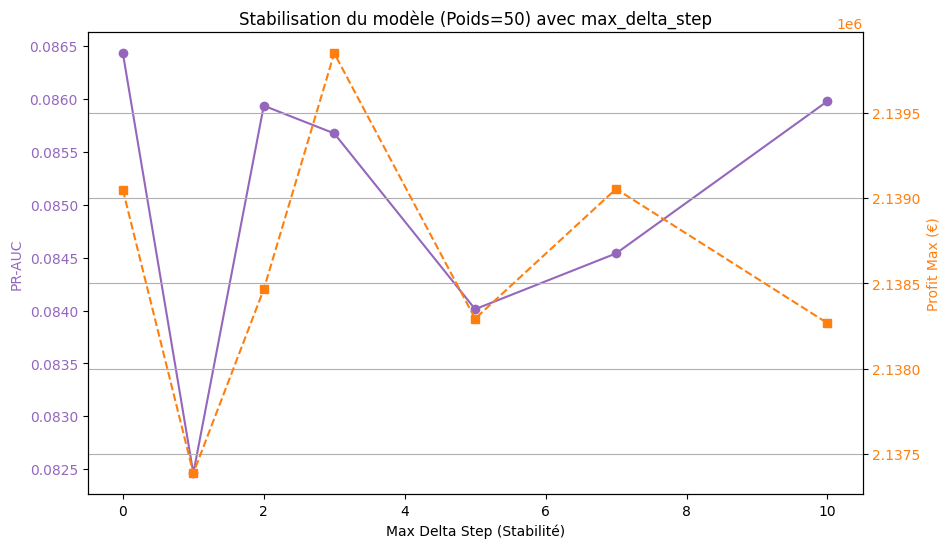

In [14]:
print("\n--- EXPLORATION AVANCÉE : Impact du max_delta_step ---")

# On teste des valeurs recommandées par la doc (1 à 10)
# 0 = Pas de limite (Défaut)
delta_steps_to_test = [0, 1, 2, 3, 5, 7, 10]
results_delta = []

# TON CHAMPION ACTUEL (Fixé à 50 suite à l'expérience précédente)
best_weight = 50 

print(f"Test avec scale_pos_weight fixe à {best_weight}")

for delta in delta_steps_to_test:
    model = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        scale_pos_weight=best_weight, # On garde le gagnant
        max_delta_step=delta,         # Le paramètre à tester
        tree_method='hist',
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    model.fit(X_train, y_train)
    
    # Prédictions
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # 1. PR-AUC
    precisions, recalls, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recalls, precisions)
    
    # 2. Profit Max
    amounts_test = X_test['Montant'].values
    profits = [calculate_exact_profit(y_test, y_probs, t, amounts_test) for t in np.linspace(0.5, 0.99, 50)]
    max_prof = max(profits)
    
    results_delta.append({
        'Max_Delta_Step': delta,
        'PR-AUC': pr_auc,
        'Max_Profit': max_prof
    })
    print(f"Delta {delta:2d} -> PR-AUC: {pr_auc:.4f} | Max Profit: {max_prof:,.0f} €")

# Visualisation
df_delta = pd.DataFrame(results_delta)

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:purple'
ax1.set_xlabel('Max Delta Step (Stabilité)')
ax1.set_ylabel('PR-AUC', color=color)
ax1.plot(df_delta['Max_Delta_Step'], df_delta['PR-AUC'], marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('Profit Max (€)', color=color)
ax2.plot(df_delta['Max_Delta_Step'], df_delta['Max_Profit'], marker='s', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f"Stabilisation du modèle (Poids={best_weight}) avec max_delta_step")
plt.grid(True)
plt.show()


--- EXPLORATION AVANCÉE : Impact de la Profondeur (max_depth) ---
Config fixe : scale_pos_weight=50, max_delta_step=0
Depth  3 -> PR-AUC: 0.0739 | Max Profit: 2,136,708 €
Depth  4 -> PR-AUC: 0.0776 | Max Profit: 2,141,413 €
Depth  5 -> PR-AUC: 0.0830 | Max Profit: 2,142,637 €
Depth  6 -> PR-AUC: 0.0864 | Max Profit: 2,139,047 €
Depth  7 -> PR-AUC: 0.0841 | Max Profit: 2,137,847 €
Depth  8 -> PR-AUC: 0.0831 | Max Profit: 2,131,255 €
Depth 10 -> PR-AUC: 0.0729 | Max Profit: 2,124,544 €
Depth 12 -> PR-AUC: 0.0645 | Max Profit: 2,111,211 €


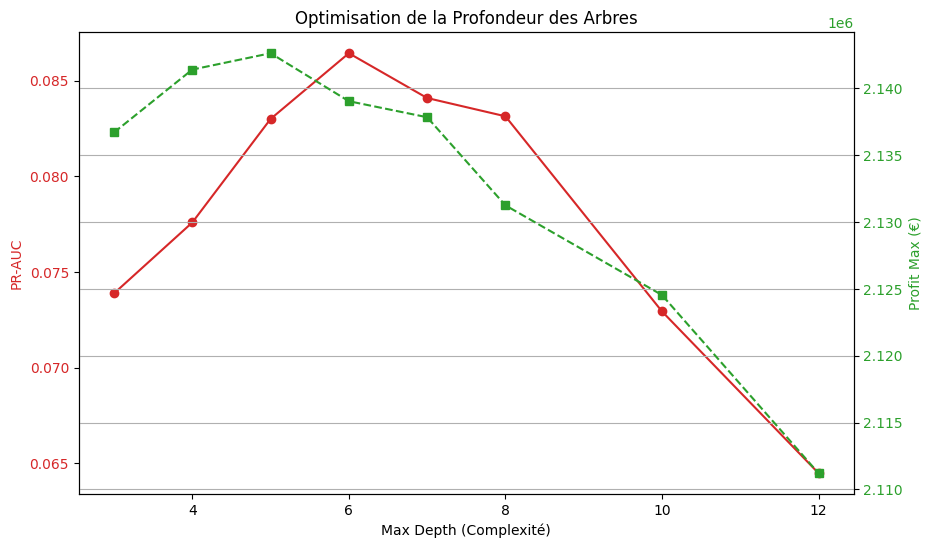

In [15]:
print("\n--- EXPLORATION AVANCÉE : Impact de la Profondeur (max_depth) ---")

# On teste autour de notre valeur actuelle (6)
depths_to_test = [3, 4, 5, 6, 7, 8, 10, 12]
results_depth = []

# Paramètres figés du Champion
best_weight = 50
best_delta = 0 # (ou la valeur que tu as gardée)

print(f"Config fixe : scale_pos_weight={best_weight}, max_delta_step={best_delta}")

for depth in depths_to_test:
    model = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=depth,      # Le paramètre variable
        scale_pos_weight=best_weight,
        max_delta_step=best_delta,
        tree_method='hist',
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    model.fit(X_train, y_train)
    
    # Prédictions
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # 1. PR-AUC
    precisions, recalls, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recalls, precisions)
    
    # 2. Profit Max
    amounts_test = X_test['Montant'].values
    profits = [calculate_exact_profit(y_test, y_probs, t, amounts_test) for t in np.linspace(0.5, 0.99, 50)]
    max_prof = max(profits)
    
    results_depth.append({
        'Max_Depth': depth,
        'PR-AUC': pr_auc,
        'Max_Profit': max_prof
    })
    print(f"Depth {depth:2d} -> PR-AUC: {pr_auc:.4f} | Max Profit: {max_prof:,.0f} €")

# Visualisation
df_depth = pd.DataFrame(results_depth)

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Max Depth (Complexité)')
ax1.set_ylabel('PR-AUC', color=color)
ax1.plot(df_depth['Max_Depth'], df_depth['PR-AUC'], marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('Profit Max (€)', color=color)
ax2.plot(df_depth['Max_Depth'], df_depth['Max_Profit'], marker='s', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f"Optimisation de la Profondeur des Arbres")
plt.grid(True)
plt.show()

## balanced bagging


In [8]:
from imblearn.ensemble import BalancedBaggingClassifier

print("\n--- TEST ULTIME 1 : Balanced Bagging avec XGBoost ---")

# On utilise un XGBoost "léger" comme estimateur de base car on va en lancer 10 ou 20
xgb_base = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    tree_method='hist',
    n_jobs=1,  # Important : on parallélise via le Bagging, pas via XGBoost
    random_state=42
)

# Le Bagging va créer 10 modèles.
# Chaque modèle verra : Toutes les fraudes + Autant de non-fraudes (Ratio 1:1)
bbc = BalancedBaggingClassifier(
    estimator=xgb_base,
    n_estimators=15,  # 15 arbres votants
    replacement=False,
    sampling_strategy='not minority', # Undersample la majorité pour égaler la minorité
    random_state=42,
    n_jobs=-1 # Parallélisation ici
)

print("Entraînement du Balanced Bagging (peut prendre un peu de temps)...")
bbc.fit(X_train, y_train)

# Évaluation
y_probs_bbc = bbc.predict_proba(X_test)[:, 1]

# Calculs Metrics
precisions, recalls, _ = precision_recall_curve(y_test, y_probs_bbc)
pr_auc = auc(recalls, precisions)

amounts_test = X_test['Montant'].values
profits = [calculate_exact_profit(y_test, y_probs_bbc, t, amounts_test) for t in np.linspace(0.5, 0.99, 50)]
max_prof_bbc = max(profits)

print(f"--- RÉSULTATS BALANCED BAGGING ---")
print(f"PR-AUC : {pr_auc:.4f}")
print(f"Profit : {max_prof_bbc:,.0f} €")


--- TEST ULTIME 1 : Balanced Bagging avec XGBoost ---
Entraînement du Balanced Bagging (peut prendre un peu de temps)...
--- RÉSULTATS BALANCED BAGGING ---
PR-AUC : 0.0902
Profit : 2,140,490 €


In [9]:
print("\n--- TEST ULTIME 2 : Cost-Sensitive Learning (Instance Weights) ---")

def calculate_sample_weights(y, amounts):
    weights = []
    y = np.array(y)
    amounts = np.array(amounts)
    r = 0.05 # Taux de marge
    
    for i in range(len(y)):
        m = amounts[i]
        label = y[i]
        
        if label == 1: # C'est une FRAUDE
            # Si le modèle se trompe (FN), on perd selon la grille du sujet
            if m <= 20: loss = 0.01 # On met un petit poids non nul pour la stabilité
            elif m <= 50: loss = 0.2 * m
            elif m <= 200: loss = 0.3 * m # Simplification 50-200
            else: loss = 0.5 * m
            weights.append(loss)
            
        else: # C'est LÉGITIME
            # Si le modèle se trompe (FP), on perd la différence de marge
            # Gain normal : 0.05 * m
            # Gain dégradé : 0.7 * 0.05 * m
            # Perte sèche : 0.3 * 0.05 * m = 0.015 * m
            weights.append(0.015 * m)
            
    return np.array(weights)

# 1. Calcul des poids pour le TRAIN set
print("Calcul des poids financiers par transaction...")
train_weights_financial = calculate_sample_weights(y_train, X_train['Montant'].values)

# Normalisation des poids (XGBoost préfère quand la somme est stable)
# On garde le ratio global mais on scale les valeurs
train_weights_financial = train_weights_financial * (len(y_train) / np.sum(train_weights_financial))

# 2. Entraînement XGBoost avec ces poids
# Note : On remet scale_pos_weight à 1 car le déséquilibre est géré par nos poids manuels !
xgb_cost = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=1, # CRUCIAL : Nos poids 'train_weights_financial' font déjà le travail !
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

print("Entraînement Cost-Sensitive...")
xgb_cost.fit(X_train, y_train, sample_weight=train_weights_financial)

# Évaluation
y_probs_cost = xgb_cost.predict_proba(X_test)[:, 1]

# On optimise le seuil (même si théoriquement 0.5 devrait être pas mal, on vérifie)
amounts_test = X_test['Montant'].values
profits = [calculate_exact_profit(y_test, y_probs_cost, t, amounts_test) for t in np.linspace(0.5, 0.99, 50)]
max_prof_cost = max(profits)

print(f"--- RÉSULTATS COST-SENSITIVE WEIGHTING ---")
print(f"Profit : {max_prof_cost:,.0f} €")

# Comparaison avec ton champion actuel (2 140 000 € ?)
diff = max_prof_cost - 2_140_000
print(f"Différence vs Champion Précédent : {diff:+,.0f} €")


--- TEST ULTIME 2 : Cost-Sensitive Learning (Instance Weights) ---
Calcul des poids financiers par transaction...
Entraînement Cost-Sensitive...
--- RÉSULTATS COST-SENSITIVE WEIGHTING ---
Profit : 2,140,920 €
Différence vs Champion Précédent : +920 €


In [10]:
from sklearn.metrics import f1_score, confusion_matrix

print("\n--- DUEL FINAL : BAGGING vs COST-SENSITIVE ---")

models_to_compare = [
    ("Balanced Bagging", y_probs_bbc),      # Assure-toi que cette variable existe encore
    ("XGB Cost-Sensitive", y_probs_cost)    # Assure-toi que cette variable existe encore
]

amounts_test = X_test['Montant'].values

for name, probs in models_to_compare:
    print(f"\n>> Analyse de : {name}")
    
    # 1. Retrouver le seuil EXACT qui donne le profit max
    thresholds = np.linspace(0.5, 0.99, 100)
    best_profit = -np.inf
    best_thresh = 0.5
    
    for t in thresholds:
        p = calculate_exact_profit(y_test, probs, t, amounts_test)
        if p > best_profit:
            best_profit = p
            best_thresh = t
            
    # 2. Calculer la F-Mesure à ce seuil précis
    y_pred_final = (probs >= best_thresh).astype(int)
    f1 = f1_score(y_test, y_pred_final)
    conf_mat = confusion_matrix(y_test, y_pred_final)
    
    print(f"Profit Max       : {best_profit:,.0f} €")
    print(f"Seuil Optimal    : {best_thresh:.3f}")
    print(f"F-Mesure associée: {f1:.4f}")
    print(f"Matrice de Confusion :\n{conf_mat}")


--- DUEL FINAL : BAGGING vs COST-SENSITIVE ---

>> Analyse de : Balanced Bagging
Profit Max       : 2,140,964 €
Seuil Optimal    : 0.876
F-Mesure associée: 0.1346
Matrice de Confusion :
[[727640  13198]
 [  5146   1427]]

>> Analyse de : XGB Cost-Sensitive
Profit Max       : 2,141,031 €
Seuil Optimal    : 0.574
F-Mesure associée: 0.1258
Matrice de Confusion :
[[727720  13118]
 [  5251   1322]]
